# GR5293 - Proj1 - Group9
## Classification on the late payment of credit cards
#### Machine learning pipeline with random forest
* Feature Engineering
* Train validation test split
* K-fold cross validation
* Rank the feature importance to interpret the result and give the orientation of further dimension reduction to enhance the depoliability of our model, state its business value
* Focus on AUC and recall!
* Plot the ranked feature importance barplot(horizontal), the AUC curve with different predictor sets
* Plot the training / testing error curve
* Plot the cv scores in feature selection (/w number of components)

### Setup

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
import gc
gc.enable()
print(os.getcwd())
mydir = os.getcwd() + "/"
%xmode plain
%matplotlib inline

/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project1-Group9/doc
Exception reporting mode: Plain


### Read in and post-process the data
#### Split the features and label
#### Post-process the data
##### Make corrections on data type
* Extract columns with "FLAG", "TYPE" in their names as categorical data
* Some columns with all integers but have "CNT", "DAYS" in their names would not be converted
* Unique value <= 10 can be interpreted as categorical
  
#### Delete some special columns by screening
* Drop predictors with AVG MODE MEDI, only keep medians
  
#### Stadardize
* Only standardize columns with non-categorical data

In [2]:
fraud_df = pd.read_csv(
    '../data/fraud_cleaned_ver3.csv', 
    header = 0
)
fraud_df = fraud_df.iloc[:,1:]
print(f'fraud_df shape: {fraud_df.shape}')

feature_df = fraud_df.iloc[:,1:]
response_df = fraud_df.loc[:,"TARGET"].astype(int)

categorical_col_list = []
for name in feature_df.columns:
    if len(feature_df[name].unique()) <= 10:
        categorical_col_list.append(name)
        feature_df[name] = feature_df[name].astype(int)

pattern_avg_mode = re.compile('(.*_AVG$|.*_MODE$)')
dup_col_list = []
for name in feature_df.columns:
    if re.search(pattern_avg_mode, name):
        dup_col_list.append(name)

feature_df.drop(
    dup_col_list,
    inplace = True, 
    axis = 1
)

from sklearn.preprocessing import MinMaxScaler
# instantiate the scalar
minmax_scalar = MinMaxScaler(
    feature_range = (0, 1)
)
# split the feature_df into categorical and non-categorical subdf
feature_df_non_categorical = feature_df[[name for name in feature_df.columns if name not in categorical_col_list]]
feature_df_categorical = feature_df[[name for name in feature_df.columns if name in categorical_col_list]]

# only transform non_categorical df
feature_df_non_categorical_minmax = minmax_scalar.fit_transform(X = feature_df_non_categorical) # return np.ndarray
# convert it into a dataframe
feature_df_std_categorical_minmax = pd.DataFrame(
    data = feature_df_non_categorical_minmax, 
    columns = feature_df_non_categorical.columns
)
# concatenate categorical df and non-categorical df
feature_df_minmax = pd.concat([feature_df_std_categorical_minmax, feature_df_categorical], axis = 1)
# dtype conversion
for name in list(feature_df_minmax.columns):
    if name in categorical_col_list:
        feature_df_minmax[name] = feature_df_minmax[name].astype(int)


fraud_df shape: (71974, 154)


/var/folders/tz/1kfts8hs47xb2vd2_6cggx300000gn/T/ipykernel_63864/2336795513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[name] = feature_df[name].astype(int)
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Define train test split function

In [3]:
def train_test_split_with_shuffle(feature_df_, response_df_ = response_df, test_size_ = 0.25):
    '''
    Implement train test split function and shuffle all the data
    Default using test_ratio = 0.25 and standardized dataframe
    Return global variables
    '''
    globals()['feature_train'], globals()['feature_test'], globals()['response_train'], globals()['response_test'] = train_test_split(
        feature_df_, 
        response_df_, 
        test_size = test_size_, 
        shuffle = True, 
        random_state = 42, 
        stratify = response_df_
    )
    globals()['response_train'] = pd.DataFrame(globals()['response_train'])
    globals()['response_test'] = pd.DataFrame(globals()['response_test'])
    list_p1 = ["feature", "response"]
    list_p2 = ["train", "test"]
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            print(f'The Size of {temp_var} is: {globals()[temp_var].shape}')

    # reshape the index
    # make them start from 0 and end at their shape[0] - 1
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            globals()[temp_var].index = np.arange(globals()[temp_var].shape[0], dtype = int)
    pass

#### Feature Engineering
* Feature selection by RFECV / SelectFromModel / PCA 
* Extreme imbalanced data -> resampling
* Only 6% of data is fraudulent this would cause the classifier onlt predict no fraudulent and get the result of 90%+ accuracy

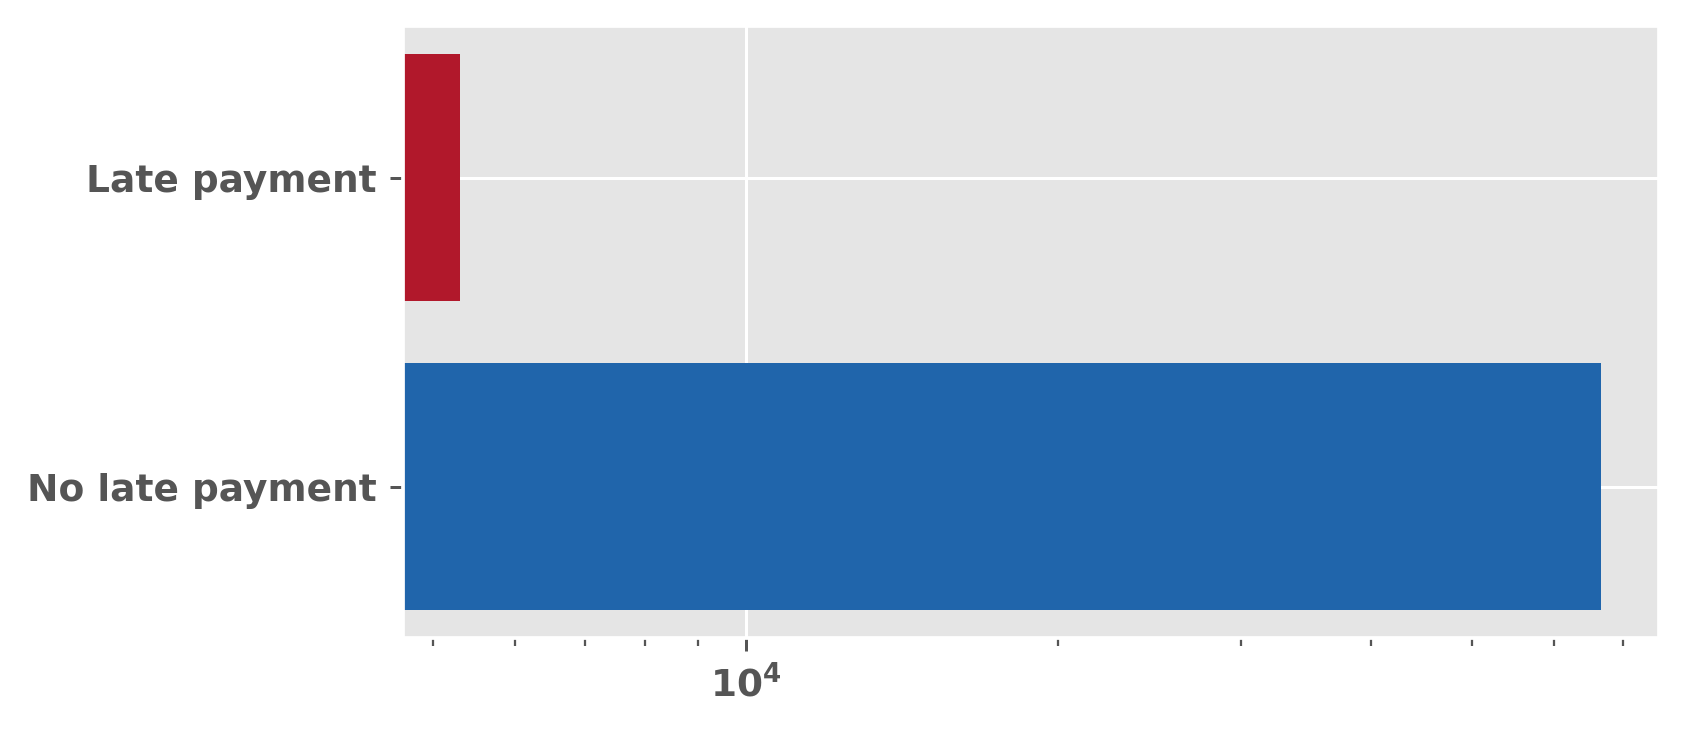

In [4]:
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams["font.weight"] = "bold"
my_colormap = cm.get_cmap(name = 'RdBu')
color_value = np.linspace(start = 0.9, stop = 0.1, num = 2)
fig, ax = plt.subplots(1, 1, figsize = (6,3), dpi = 270)
for i in np.arange(2):
    ax.barh(
        y = i, 
        width = response_df[response_df == i].shape[0], 
        label = i, 
        color = my_colormap(color_value[i])
    )
ax.set_yticks(np.arange(2), ["No late payment", "Late payment"])
ax.set_xscale('log')
# ax.set_xlabel("Count")
plt.show()

#### Resampling after train test split
* Random Under-Sampling / Random Over-Sampling / Random under-sampling with imblearn / Random over-sampling with imblearn / Under-sampling: Tomek links / Synthetic Minority Oversampling Technique (SMOTE) / NearMiss / 

Use undersampling here since the amount of data is large. (Low F1 score)
>Tomek links can extract the data from majority class "0" that are close to opposite classes. 
Try Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
def resampling(type_, feature_train_ = feature_train, response_train_ = response_train):
    if type_ == "RandomUnderSampler":
        sampler = RandomUnderSampler(
            sampling_strategy = "auto", 
            random_state = 42
        )
    elif type_ == "RandomOverSampler":
        sampler = RandomOverSampler(
            sampling_strategy = "auto", 
            random_state = 42
        )
    elif type_ == "SMOTE":
        sampler = SMOTE(
            sampling_strategy = "auto", 
            random_state = 42, 
            n_jobs = -1, 
            k_neighbors = 5
        ) 
    feature_res, response_res = sampler.fit_resample(X = feature_train_, y = response_train_)             
    return feature_res, response_res

#### Modeling
Make pipelines here

In [6]:
train_test_split_with_shuffle(feature_df_ = feature_df_minmax, response_df_ = response_df, test_size_ = 0.2)
feature_res, response_res = resampling(
    type_ = "RandomUnderSampler"
)


The Size of feature_train is: (57579, 140)
The Size of feature_test is: (14395, 140)
The Size of response_train is: (57579, 1)
The Size of response_test is: (14395, 1)
